In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [13]:
def get_model_pp_cfg(exp):
    cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/{exp}/train.yaml')
    path = Path(cfg.output.save_dir)
    model = hydra.utils.instantiate(cfg.model)
    model = load_model_state(model, path, 'model.pkl')
    post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
    return model,post_proc,cfg

In [5]:
cfg = OmegaConf.load(default_conf)

In [159]:
cfg.output.project = 'Fig_sim_density'

cfg.run_name ='sim_density_fac2_2'
cfg.data_path.image_path = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac2_1/mRNAlevel_100/foci/strong/w1*.tif'
cfg.data_path.psf_path = None
cfg.ground_truth = None
cfg.microscope.psf_extent_zyx = [11,21,21]

cfg.bg_estimation.smoothing_filter_size = 10
cfg.foci.n_foci_avg = 2

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,:,100:150,100:150]'
cfg.evaluation.px_size =  [100,100,300]

cfg.PSF.gauss_radii = [1.2,1.2,1.2]
cfg.prob_generator.low = 0.0015
cfg.prob_generator.high = 0.0015

cfg.microscope.multipl = 2.
cfg.pointprocess.min_int = 0.3

cfg.noise.theta = 2.
cfg.noise.baseline = 0.

cfg.autoencoder.opt.lr = 7e-3

cfg.supervised.num_iter = 6000

In [160]:
OmegaConf.save(cfg, f'../config/experiment/{cfg.run_name}.yaml')

In [127]:
# cfg = OmegaConf.load('../config/experiment/sim_density_fac1_1.yaml')
# cfg.run_name ='sim_density_fac1_1b'
# cfg.supervised.num_iter = 0
# cfg.autoencoder.step_size = 2000

# cfg.autoencoder.opt.lr = 1e-2

# cfg.data_path.model_init = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/nb_run/sim_density_fac1_1/sl_save'
# OmegaConf.save(cfg, f'../config/experiment/{cfg.run_name}.yaml')

In [128]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

20 volumes


In [129]:
# basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1/'
# img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 503, 'random', 'NR', 0)
# axes = plot_3d_projections(img[0], 'max', size=15)
# gt_px = nm_to_px(gt_df, px_size=[100,100,300])
# axes[0].scatter(gt_px['x'],gt_px['y'], color='red', s=5.)
# axes[1].scatter(gt_px['x'],gt_px['z'], color='red', s=5.)
# axes[2].scatter(gt_px['y'],gt_px['z'], color='red', s=5.)
# perf_df, matches, shift = matching(gt_df, fq_gmm_df, print_res=True)

In [130]:
# x, local_rate, background = next(iter(decode_dl))
# sim_vars = PointProcessUniform(local_rate, min_int=decode_dl.min_int).sample()
# xsim = micro(*sim_vars)
# xsim = micro.noise(xsim, background).sample()
# plt.hist(cpu(xsim).reshape(-1))

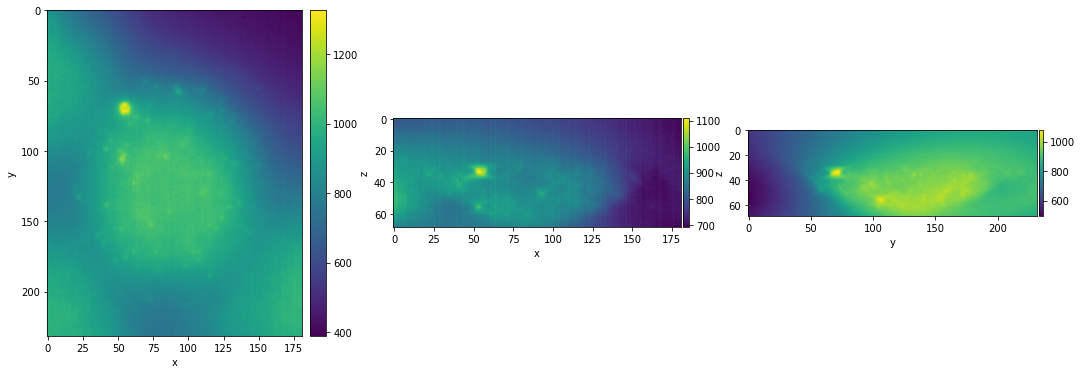

In [131]:
_ = plot_3d_projections(img_3d[0])

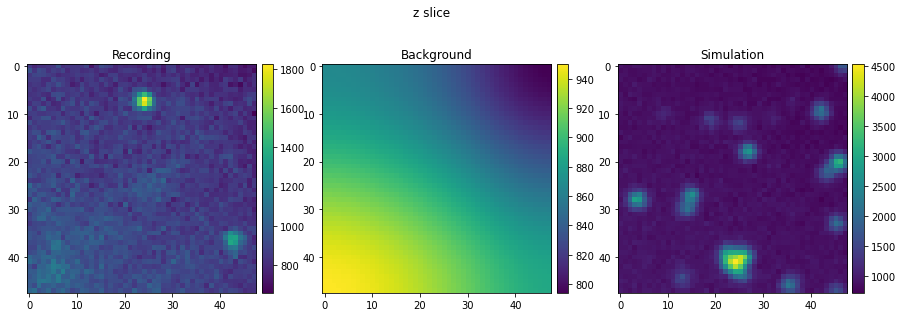

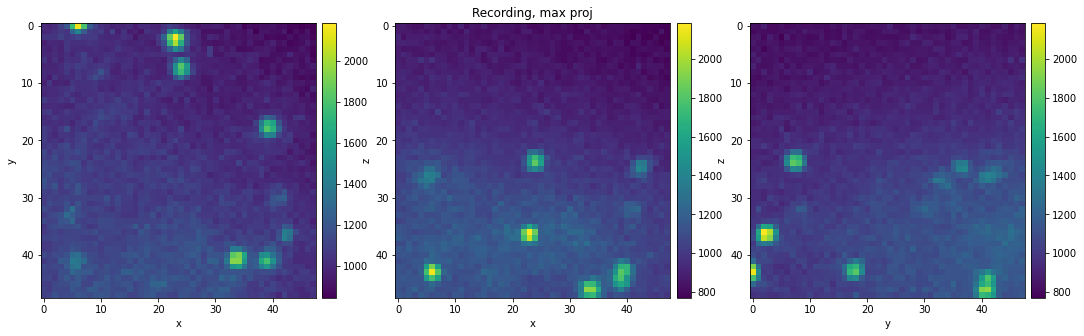

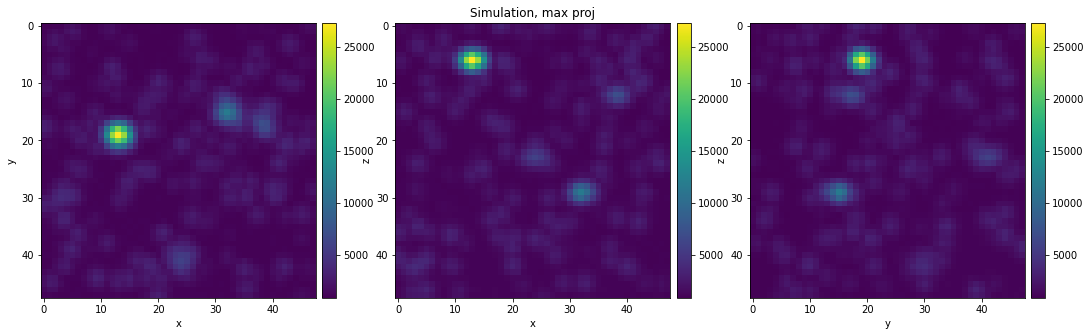

In [137]:
get_simulation_statistics(decode_dl, micro, int_threshold=1500)

In [153]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=sim_density_fac05_2'

In [224]:
exp = 'sim_density_fac05_2'
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/nb_run/{exp}/train.yaml')

In [225]:
path = Path(cfg.output.save_dir)
model = hydra.utils.instantiate(cfg.model)
model = load_model_state(model, path, 'model.pkl')
post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
psf, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(path/'psf.pkl'))
psf.cuda()

psf_init, _, micro = load_psf_noise_micro(cfg)
psf_init.load_state_dict(torch.load(path/'psf_init.pkl'))
psf_init.cuda()

LinearInterpolatedPSF()

tensor(1.0024, device='cuda:0', grad_fn=<SumBackward0>)

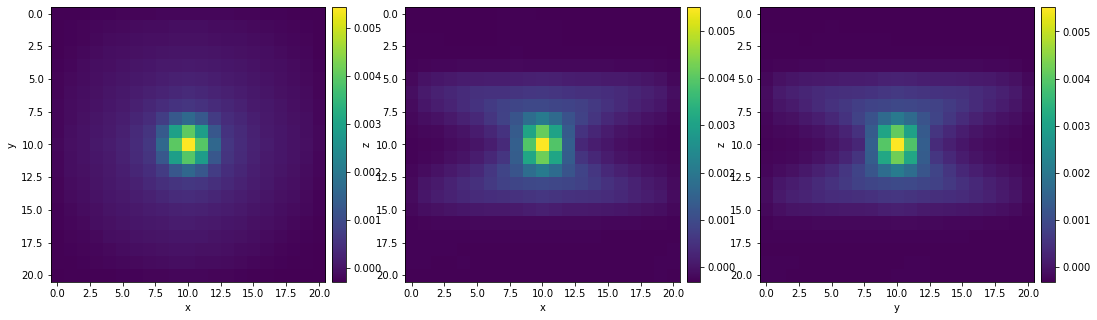

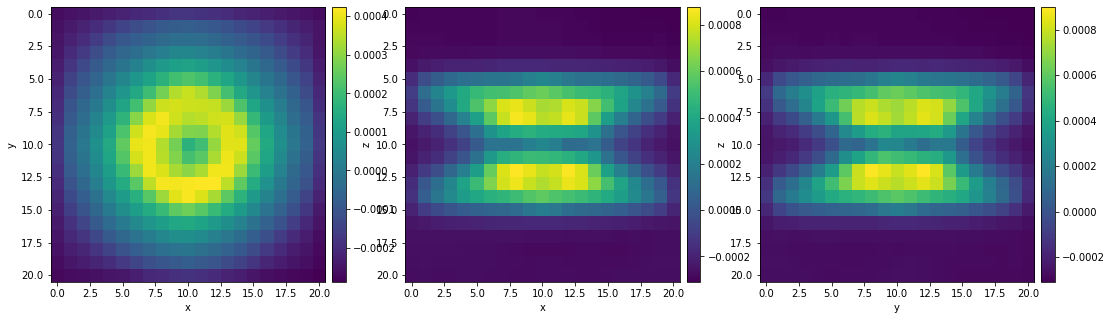

In [226]:
plot_3d_projections(psf.psf_volume[0])
plot_3d_projections(psf.psf_volume[0]-psf_init.psf_volume[0], 'mean')
psf.psf_volume[0].sum()

In [227]:
cfg.dataloader.bs = 1
img_3d, decode_dl = get_dataloader(cfg)

20 volumes


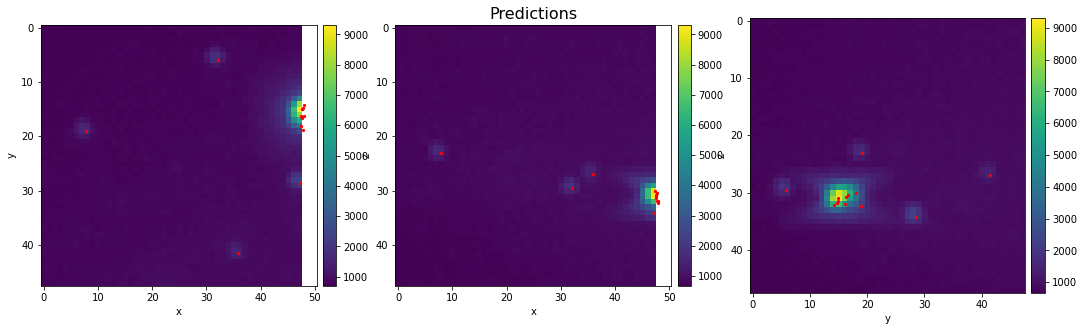

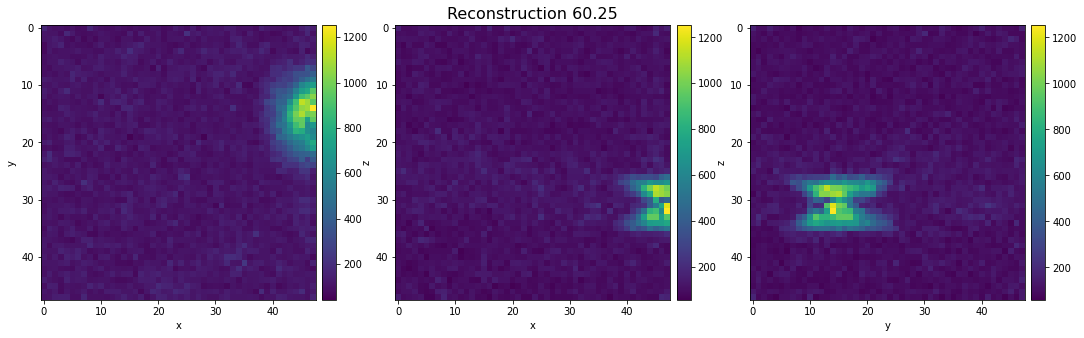

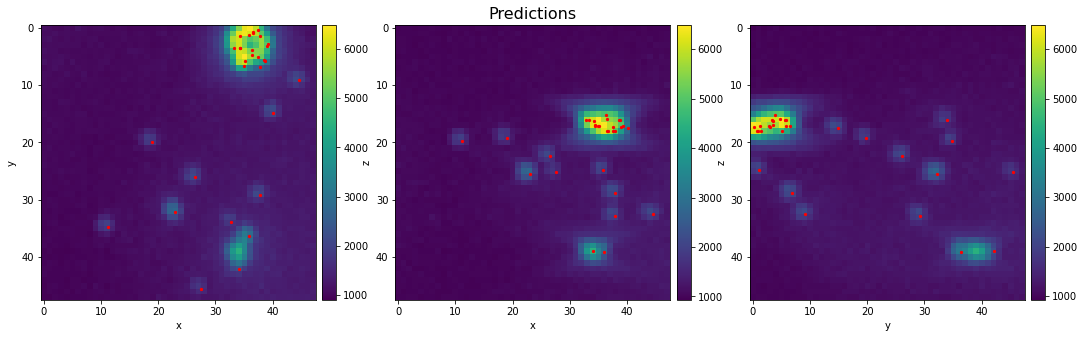

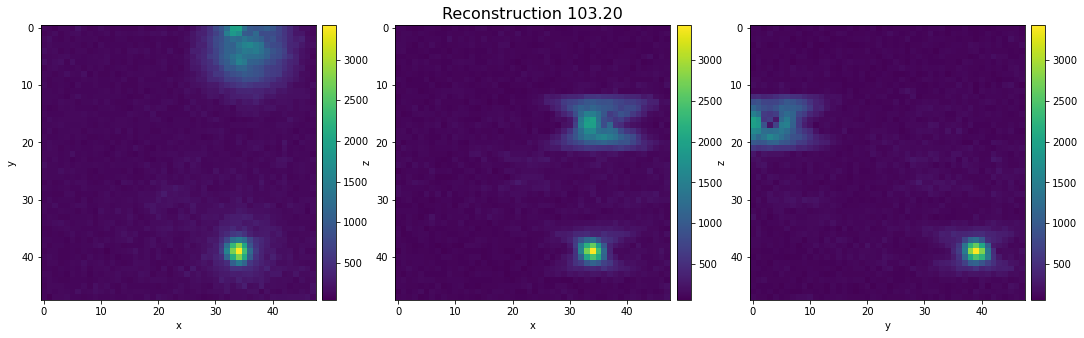

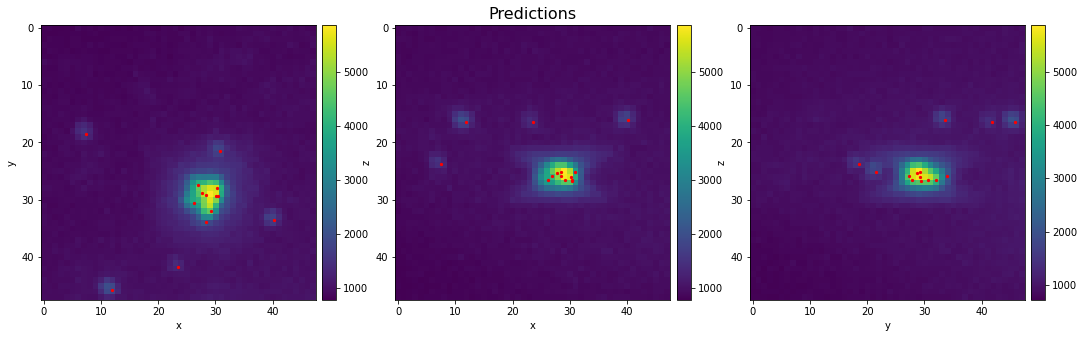

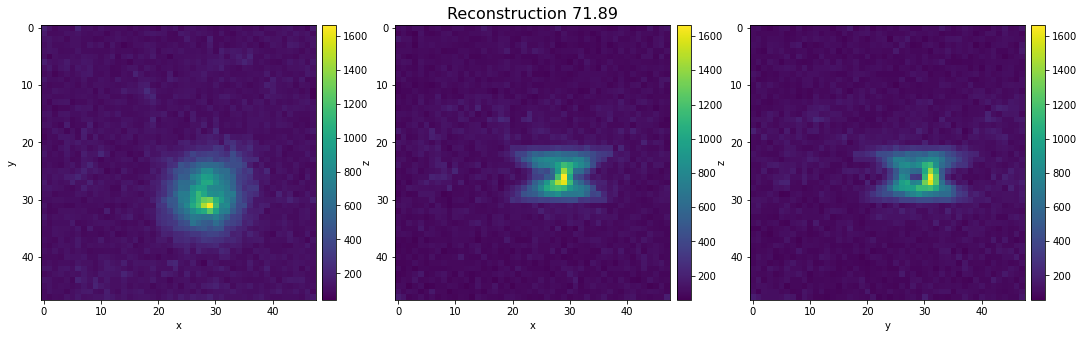

In [228]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3, int_threshold=5000)

In [229]:
# basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_1//'
# img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 250, 'random', 'NR', 0, shift=[-38, -38, -110])
# model.cuda()
# with torch.no_grad():
#     dec_df = shift_df(post_proc(model(img[None].cuda()), 'df'), [0,0,0])

In [230]:
# plt.hist(dec_df['int'])

In [231]:
# sl = np.s_[:,:,150:200,50:100]
# px_preds = nm_to_px(dec_df, px_size=cfg.evaluation.px_size)
# px_gt = nm_to_px(gt_df, px_size=cfg.evaluation.px_size)
# px_preds = crop_df(px_preds, sl)
# px_gt = crop_df(px_gt, sl)

# px_preds = px_preds[px_preds['int'] > 0.3]

# axes = plot_3d_projections(img[0][sl[1:]], 'max')

# axes[0].scatter(px_preds['x'],px_preds['y'], color='red', s=5.)
# axes[1].scatter(px_preds['x'],px_preds['z'], color='red', s=5.)
# axes[2].scatter(px_preds['y'],px_preds['z'], color='red', s=5.)

# axes[0].scatter(px_gt['x'],px_gt['y'], color='black', s=5., marker='+')
# axes[1].scatter(px_gt['x'],px_gt['z'], color='black', s=5., marker='+')
# axes[2].scatter(px_gt['y'],px_gt['z'], color='black', s=5., marker='+')

In [35]:
model,post_proc,cfg = get_model_pp_cfg('sim_density_fac2_2')
_ = model.cuda()

In [40]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac2_1//'
densities = [250,500,1000,2000,4000]
n_cells = 5

model.cuda()

dec_col = []

# Run once to get shift
# 05 : 0.2
# 1  : 0.2
# 2  : 0.3
int_threshold = 0.0

dec_df = []
gtc_df = []
for i in range(n_cells):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 500, 'random', 'NR', i)
    gtc_df.append(gt_df)
    with torch.no_grad():
        curr_df = shift_df(post_proc(model(img[None].cuda()), 'df'), [-100,-100,-100])
        dec_df.append(shift_df(curr_df, [0,0,0]))
        
gtc_df = cat_emitter_dfs(gtc_df)
dec_df = cat_emitter_dfs(dec_df)
dec_df = dec_df[dec_df['int'] > int_threshold]
perf_df, matches, shift = matching(gtc_df, dec_df, print_res=True)

# Run over all densities

for d in densities:
    print(d)
    gtc_df = []
    dec_df = []
    for i in range(n_cells):
        img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, d, 'random', 'NR', i)
        gtc_df.append(gt_df)
        with torch.no_grad():
            curr_df = shift_df(post_proc(model(img[None].cuda()), 'df'), [-100,-100,-100])
            dec_df.append(shift_df(curr_df, shift))
        
    gtc_df = cat_emitter_dfs(gtc_df)
    dec_df = cat_emitter_dfs(dec_df)
    
    dec_df = dec_df[dec_df['int'] > int_threshold]
        
    perf_df, matches, _ = matching(gtc_df, dec_df, print_res=True)
    dec_col.append(perf_df)

Recall: 0.882
Precision: 0.800
Jaccard: 72.272
RMSE_vol: 217.242
Eff_3d: -12.104
FN: 326.0 FP: 609.0
Shift: 13.00,12.54,-199.37
250
Recall: 0.931
Precision: 0.712
Jaccard: 67.576
RMSE_vol: 62.822
Eff_3d: 54.856
FN: 94.0 FP: 512.0
Shift: 0.47,2.30,-9.99
500


KeyboardInterrupt: 

In [ ]:
Recall: 0.865
Precision: 0.986
Jaccard: 85.470
RMSE_vol: 174.918
Eff_3d: 11.342
FN: 352.0 FP: 31.0
Shift: 14.98,15.96,-166.25
250
Recall: 0.879
Precision: 0.988
Jaccard: 86.982
RMSE_vol: 38.392
Eff_3d: 76.806
FN: 164.0 FP: 15.0
Shift: 0.55,-0.23,-5.82
500
Recall: 0.865
Precision: 0.986
Jaccard: 85.470
RMSE_vol: 41.595
Eff_3d: 74.630
FN: 352.0 FP: 31.0
Shift: -0.63,0.27,-4.34
1000

In [ ]:
with open(basedir + 'dec1_perf_dfs.pkl', 'wb') as f:
    pickle.dump({'dec':dec_col, 'densities':[250,500,1000,2000,4000]}, f)

In [42]:
base_str = 'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/operf.log -e /groups/turaga/home/speisera/logs/eperf.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/get_perf.py '
#        exp                 datadir           #int #resname
evals = ['sim_density_fac2_2 sim_density_fac2_1 0.3 2',
         'sim_density_fac1_2 sim_density_fac1_1 0.0 2',
         'sim_density_fac05_2 sim_density_fac05_1 0.0 2']

with open('run_slurm.sh', 'w') as f: 
    for s in evals:
        exec_str = base_str + s +  '\n'
        print(exec_str)
        f.write(exec_str)

bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/operf.log -e /groups/turaga/home/speisera/logs/eperf.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/get_perf.py sim_density_fac2_2 sim_density_fac2_1 0.3 2

bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/operf.log -e /groups/turaga/home/speisera/logs/eperf.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/get_perf.py sim_density_fac1_2 sim_density_fac1_1 0.0 2

bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/operf.log -e /groups/turaga/home/speisera/logs/eperf.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/get_perf.py sim_density_fac05_2 sim_density_fac05_1 0.0 2



In [32]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1///'
n_cells = 20

model.cuda()

dec_col = []

int_threshold = 0.1

dec_df = []
gtc_df = []
for i in range(5):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', i)
    gtc_df.append(gt_df)
    with torch.no_grad():
        curr_df = shift_df(post_proc(model(img[None].cuda()), 'df'), [-100,-100,-100])
        dec_df.append(shift_df(curr_df, [0,0,0]))
        
gtc_df = cat_emitter_dfs(gtc_df)
dec_df = cat_emitter_dfs(dec_df)
dec_df = dec_df[dec_df['int'] > int_threshold]
perf_df, matches, shift = matching(gtc_df, dec_df, print_res=True)


gtc_df = []
dec_df = []
for i in range(n_cells):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', i)
    gtc_df.append(gt_df)
    with torch.no_grad():
        curr_df = shift_df(post_proc(model(img[None].cuda()), 'df'), [-100,-100,-100])
        dec_df.append(shift_df(curr_df, shift))

gtc_df = cat_emitter_dfs(gtc_df)
dec_df = cat_emitter_dfs(dec_df)

dec_df = dec_df[dec_df['int'] > int_threshold]

perf_df, matches, _ = matching(gtc_df, dec_df, print_res=True)
dec_col.append(perf_df)

Recall: 0.742
Precision: 0.954
Jaccard: 71.603
RMSE_vol: 162.577
Eff_3d: 13.894
FN: 143.0 FP: 20.0
Shift: 16.75,14.37,-151.39


KeyboardInterrupt: 

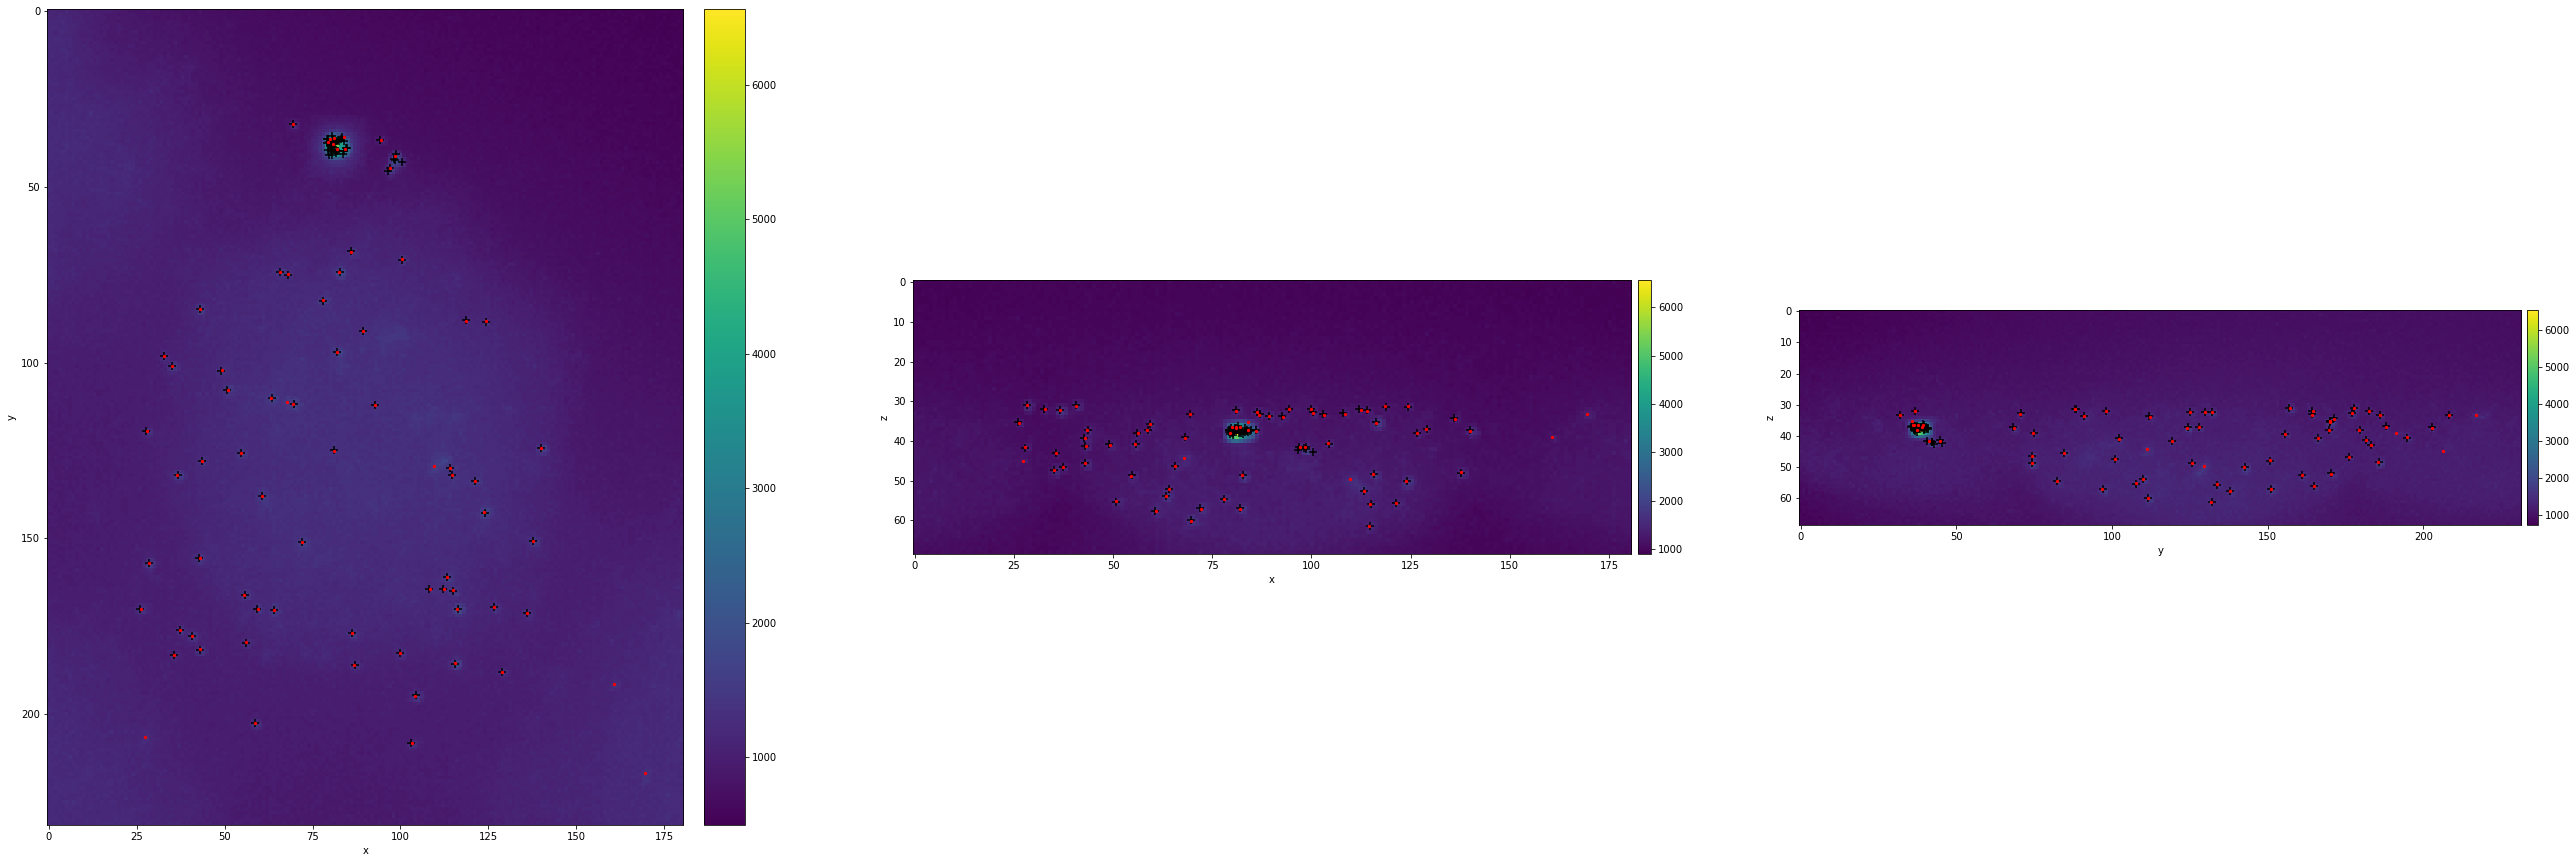

In [215]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1//'
ind = 5
img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', ind)
axes = plot_3d_projections(img[0], 'max', size=15)
sub_df = dec_df[dec_df['frame_idx'] == ind]

gt_px = nm_to_px(gt_df, px_size=[100,100,300])
dec_px = nm_to_px(sub_df, px_size=[100,100,300])
axes[0].scatter(gt_px['x'],gt_px['y'], color='black', marker='+', s=50.)
axes[1].scatter(gt_px['x'],gt_px['z'], color='black', marker='+', s=50.)
axes[2].scatter(gt_px['y'],gt_px['z'], color='black', marker='+', s=50.)

axes[0].scatter(dec_px['x'],dec_px['y'], color='red', s=5.)
axes[1].scatter(dec_px['x'],dec_px['z'], color='red', s=5.)
axes[2].scatter(dec_px['y'],dec_px['z'], color='red', s=5.)

# perf_df, matches, _ = matching(gt_df, sub_df, print_res=True)

In [6]:
from decode_fish.funcs.fit_psf import get_peaks_3d
from decode_fish.funcs.fit_psf import plot_detection

In [15]:
model,post_proc,cfg = get_model_pp_cfg('nb_run/sim_density_fac1_2')
_ = model.cpu()

In [40]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1//'

mults = [2.,2.5,3.,3.5,4.]

dec_count_col = []
prob_sum_col = []

for m in mults:
        
    model,post_proc,cfg = get_model_pp_cfg(f'sweep_f1/multipl:{str(m)}/')
    _ = model.cuda()

    box_sz = 10
    n_cells = 20
    gt_counts = []
    fq_counts = []
    dec_counts = []
    prob_sums = []

    for i in tqdm(range(n_cells)):

        img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', i)
        gt_px = nm_to_px(gt_df, px_size=[100,100,300])
        fq_px = nm_to_px(fq_gmm_df, px_size=[100,100,300])
        with torch.no_grad():
            res_dict = model(img[None].cuda())
            dec_df = shift_df(post_proc(res_dict, 'df'), [-100,-100,-100])
            free_mem()
        dec_px = nm_to_px(dec_df, px_size=[100,100,300])

        try:
            coords_xyz = get_peaks_3d(img[0], threshold=2000, min_distance=10)
        except AssertionError:
            continue
        coords_zyx = coords_xyz[:,::-1]

        for c in coords_zyx:
            sl = np.s_[:,c[0]-box_sz:c[0]+box_sz+1, c[1]-box_sz:c[1]+box_sz+1, c[2]-box_sz:c[2]+box_sz+1]
            gt_crop = crop_df(gt_px, sl)
            fq_crop = crop_df(fq_px, sl)
            dec_crop = crop_df(dec_px, sl)
            prob_crop = torch.sigmoid(res_dict['logits'])[0][sl]

            gt_counts.append(len(gt_crop))
            fq_counts.append(len(fq_crop))
            dec_counts.append(len(dec_crop))
            prob_sums.append(prob_crop.sum().item())
            
    dec_count_col.append(dec_counts)
    prob_sum_col.append(prob_sums)

100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


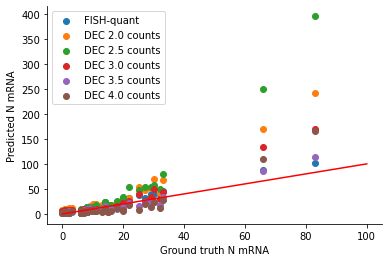

In [41]:
import seaborn as sns
plt.scatter(gt_counts, fq_counts, label='FISH-quant')
for i,c in enumerate(dec_count_col):
    plt.scatter(gt_counts, c, label=f'DEC {mults[i]} counts')
    

# plt.scatter(gt_counts, prob_sums, label='DEC probs')

plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
sns.despine()
# print('Corr. FQ: ', np.corrcoef([gt_counts, fq_counts])[0,1])
# print('Corr. DECODE: ', np.corrcoef([gt_counts, dec_counts])[0,1])

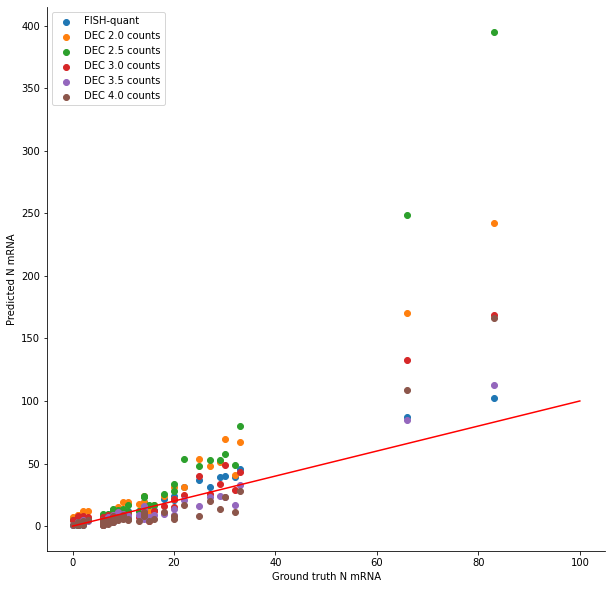

In [43]:
import seaborn as sns
plt.figure(figsize=(10,10))
plt.scatter(gt_counts, fq_counts, label='FISH-quant')
for i,c in enumerate(dec_count_col):
    plt.scatter(gt_counts, c, label=f'DEC {mults[i]} counts')
    

# plt.scatter(gt_counts, prob_sums, label='DEC probs')

plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
sns.despine()
# print('Corr. FQ: ', np.corrcoef([gt_counts, fq_counts])[0,1])
# print('Corr. DECODE: ', np.corrcoef([gt_counts, dec_counts])[0,1])

Corr. FQ:  0.9905332494930513
Corr. DECODE:  0.8755287013249105


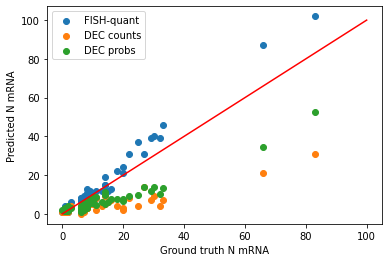

In [12]:
plt.scatter(gt_counts, fq_counts, label='FISH-quant')
plt.scatter(gt_counts, dec_counts, label='DEC counts')
plt.scatter(gt_counts, prob_sums, label='DEC probs')

plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
print('Corr. FQ: ', np.corrcoef([gt_counts, fq_counts])[0,1])
print('Corr. DECODE: ', np.corrcoef([gt_counts, dec_counts])[0,1])